# Cats Vs. Dogs Classifier

#### This is a fundamental deep learning exercise to start working with python and the convolutional neural networks (CNN) provided by Keras (Supported by Tensorflow).

The data used in this exercise is given by the **Kaggle competition** and can be downloaded <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">HERE</a>.

### Import the required libraries.

In [10]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


### Set image properties.
We'll be working on 128x128 color images.

In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

### Set up Dataset.
The Kaggle images (on the train dataset) are labeled with the name of the category (cat or dog) followed by a dot ('.') and an ID (int).

In [17]:
filenames=os.listdir("./data/train")
categories=[]
for x in filenames:
    #Image name example: 'dog.101.jpg'
    #We keep only the name of the category (dog or cat)
    category=x.split('.')[0]
    #Save categories on list.
    if category=='dog':
        categories.append('dog')
    else:
        categories.append('cat')
#Create the dataframe with the image's name - category relationship.
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

#Repeat for test data
filenames=os.listdir("./data/test")
categories=[]
for x in filenames:
    #Image name example: 'dog.101.jpg'
    #We keep only the name of the category (dog or cat)
    category=x.split('.')[0]
    #Save categories on list.
    if category=='dog':
        categories.append('dog')
    else:
        categories.append('cat')
#Create the dataframe with the image's name - category relationship.
df_test=pd.DataFrame({
    'filename':filenames,
    'category':categories
})
print(df)
print(df_test)

           filename category
0         cat.0.jpg      cat
1         cat.1.jpg      cat
2        cat.10.jpg      cat
3       cat.100.jpg      cat
4      cat.1000.jpg      cat
...             ...      ...
24995  dog.9995.jpg      dog
24996  dog.9996.jpg      dog
24997  dog.9997.jpg      dog
24998  dog.9998.jpg      dog
24999  dog.9999.jpg      dog

[25000 rows x 2 columns]
        filename category
0          1.jpg      cat
1         10.jpg      cat
2        100.jpg      cat
3       1000.jpg      cat
4      10000.jpg      cat
...          ...      ...
12495   9995.jpg      cat
12496   9996.jpg      cat
12497   9997.jpg      cat
12498   9998.jpg      cat
12499   9999.jpg      cat

[12500 rows x 2 columns]


### Set up the model (CNN).

In [4]:
model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Set callbacks and learning rate.

In [5]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

### Create train and validation datasets.

In [18]:
#Split data in 80% training, 20% validation.
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

#Drop index column from dataframes.
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = df_test.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
total_test =test_df.shape[0]
batch_size=15

### Set up image generators using the ImageDataGeneratos class from Keras.

In [19]:
#Set generator for train dataset.
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
#Generate the train images
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./data/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

#Set generator for validation dataset.
validation_datagen = ImageDataGenerator(rescale=1./255)

#Generate the validation images
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./data/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)
#Set generator for test dataset.
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
#Generate the test images
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                 "./data/test/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 1 classes.


### Train the CNN

*We need to be carefull here since the CNN we're using is complex and based on hardware features it may take long to train*

In [29]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

d:\users\pc\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1333/1333 [==============================] - 637s 477ms/step - loss: 0.9814 - accuracy: 0.5816 - val_loss: 0.5666 - val_accuracy: 0.7049
Epoch 2/10
1333/1333 [==============================] - 595s 447ms/step - loss: 0.5686 - accuracy: 0.7092 - val_loss: 0.5136 - val_accuracy: 0.7570
Epoch 3/10
1333/1333 [==============================] - 623s 467ms/step - loss: 0.5031 - accuracy: 0.7569 - val_loss: 0.5225 - val_accuracy: 0.7534
Epoch 4/10
1333/1333 [==============================] - 628s 471ms/step - loss: 0.4567 - accuracy: 0.7844 - val_loss: 0.4865 - val_accuracy: 0.7890
Epoch 5/10
1333/1333 [==============================] - 620s 465ms/step - loss: 0.4335 - accuracy: 0.8067 - val_loss: 0.4380 - val_accuracy: 0.7960
Epoch 6/10
1333/1333 [==============================] - 623s 467ms/step - loss: 0.4135 - accuracy: 0.8115 - val_loss: 0.3895 - val_accuracy: 0.8454
Epoch 7/10
1333/1333 [==============================] - 617s 463ms/step - loss: 0.3994 - accuracy: 0.8211 - val_

### Save the model

In [30]:
model.save("./models/my_model_10_epochs.h5")

### Read model (if we have an already trained model stored in disk).

In [11]:
model = load_model('./models/my_model_10_epochs.h5')

### Plot training performance

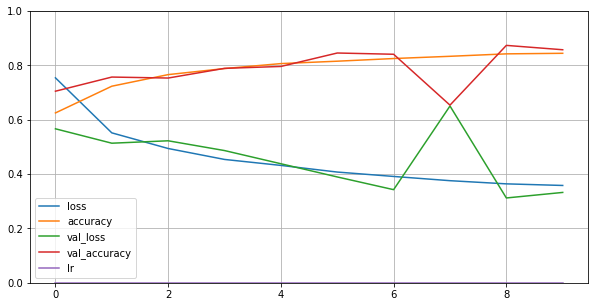

In [34]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Set up test data

In [39]:
test_filenames = os.listdir("./data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### Run predictions on test Data

In [40]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

d:\users\pc\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


### Cast labels to categories

In [41]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### VIsualize test results

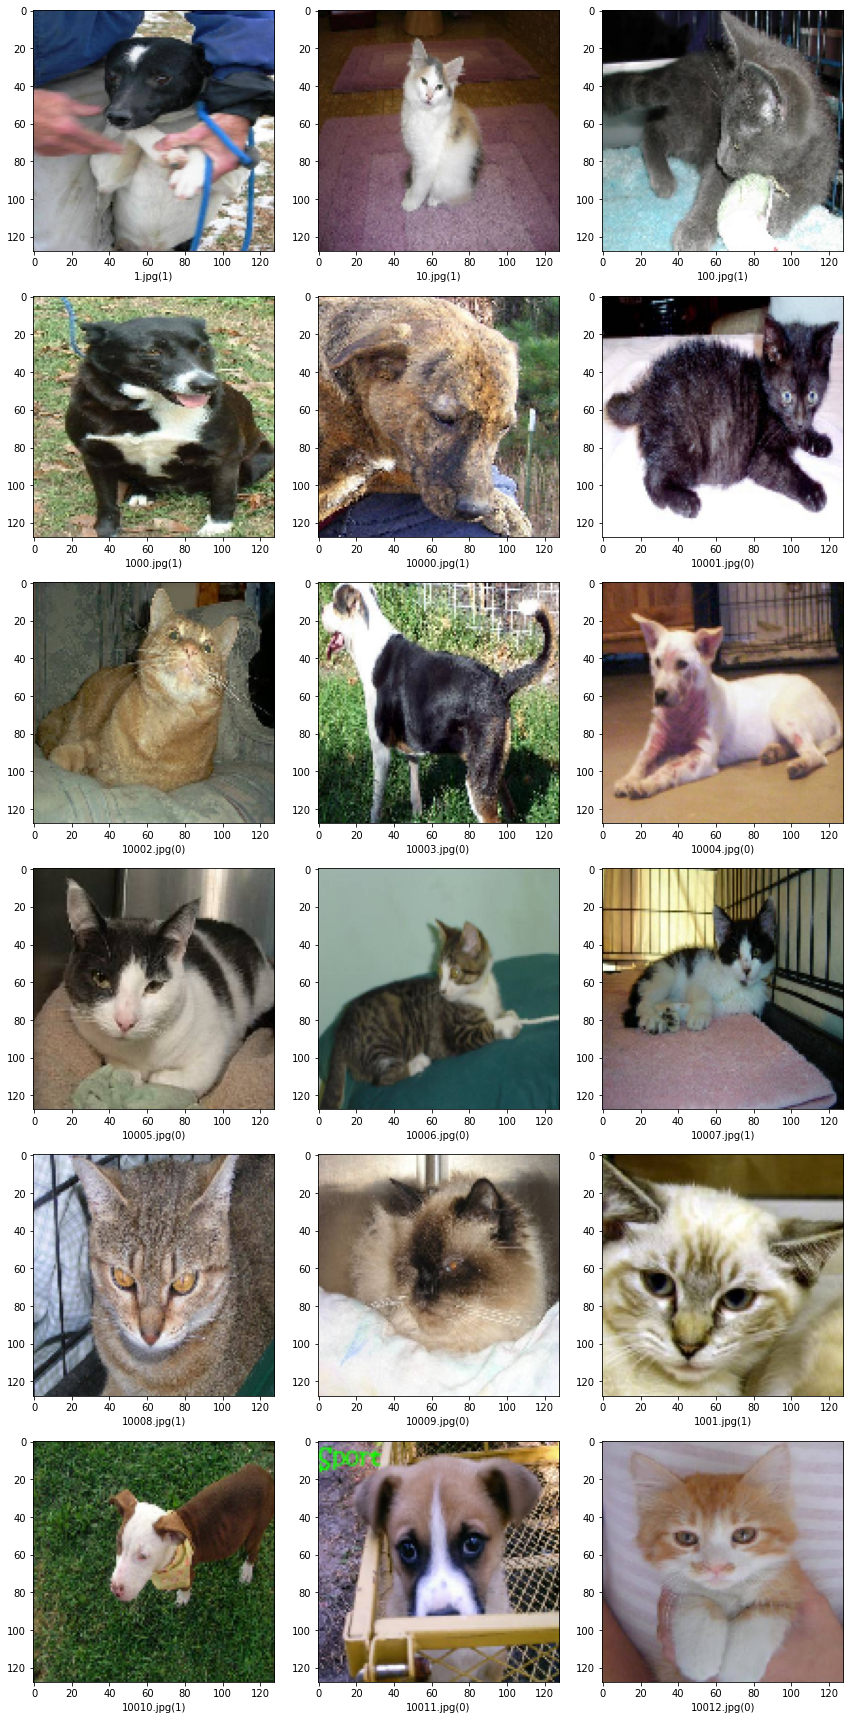

In [42]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./data/test/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()